## 1. Dado el conjunto de datos “dog & cats” con 25k y 12.5k imágenes (gatos y perros) de training and test, el cual se puede descargar aquí dogs-vs-cats.zip). Se desea:

* Aplicar la tarea de normalización a los datos para que cumplan con los requerimientos de entrada de los modelos de clasificación. Se sugiere hacer un resize(image) para la dimensión más pequeña entre ambos conjuntos.

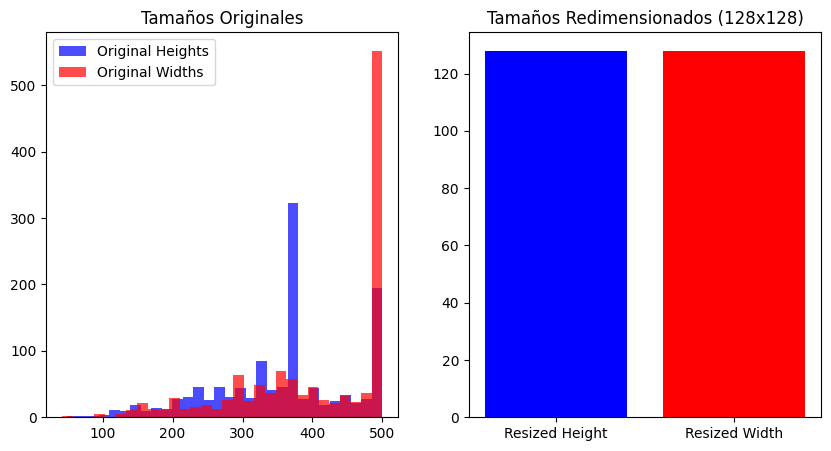

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para cargar y normalizar imágenes
def load_and_normalize_images(folder):
    images = []
    original_sizes = []
    
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        
        # Almacenar tamaño original
        original_sizes.append(img.shape[:2])
        
        # Redimensionar a un tamaño común, como 128x128
        img = cv2.resize(img, (128, 128))
        
        # Normalizar los valores de los píxeles a 0-1
        img = img / 255.0
        
        images.append(img)
    
    return np.array(images), np.array(original_sizes)

# Cargar y normalizar las imágenes del conjunto de entrenamiento
train_folder = 'dogs-vs-cats/train'
train_images, train_original_sizes = load_and_normalize_images(train_folder)

# Cargar y normalizar las imágenes del conjunto de prueba
test_folder = 'dogs-vs-cats/test1'
test_images, test_original_sizes = load_and_normalize_images(test_folder)

# Graficar comparativa de tamaños originales vs redimensionados
def plot_image_sizes(original_sizes, resized_shape):
    original_heights = [size[0] for size in original_sizes]
    original_widths = [size[1] for size in original_sizes]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(original_heights, bins=30, alpha=0.7, color='b', label='Original Heights')
    plt.hist(original_widths, bins=30, alpha=0.7, color='r', label='Original Widths')
    plt.title('Tamaños Originales')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.bar(['Resized Height', 'Resized Width'], [resized_shape[0], resized_shape[1]], color=['b', 'r'])
    plt.title('Tamaños Redimensionados (128x128)')
    plt.show()

import random

# Función para seleccionar una muestra de las imágenes
def sample_image_sizes(original_sizes, sample_fraction=0.05):
    sample_size = int(len(original_sizes) * sample_fraction)
    return random.sample(list(original_sizes), sample_size)

# Tomar una muestra del 5% de las imágenes
sampled_train_original_sizes = sample_image_sizes(train_original_sizes, sample_fraction=0.05)

# Mostrar gráfica con el 5% de las imágenes
plot_image_sizes(sampled_train_original_sizes, (128, 128))

## Utilizar la técnica, stratified 10-fold cross-validation (CV) para mostrar los resultados a nivel de promedio y desviación estándar de cada métrica supervisada considerada para esta tarea (AUC, Precision, Recall, F1-score). Investigar la técnica k-fold Cross-Validation y las métricas solicitadas para aplicarla correctamente.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC  # Usamos SVM como clasificador
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

# Aplanar las imágenes para usarlas en el modelo
X_flat = train_images.reshape(train_images.shape[0], -1)

# Etiquetas: 1 para perro, 0 para gato
y = np.array([1 if 'dog' in img else 0 for img in os.listdir(train_folder)])

# Crear el modelo SVM
model = SVC(probability=True)  # Usamos SVC con probabilidad para calcular AUC

# Definir el Stratified K-Fold CV
skf = StratifiedKFold(n_splits=10)

# Listas para almacenar los resultados de cada métrica
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Aplicar 10-fold cross-validation
for train_index, test_index in skf.split(X_flat, y):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo SVM
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    auc_scores.append(roc_auc_score(y_test, y_prob))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Mostrar los resultados promedio y desviación estándar
print(f"AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
